# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [22]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler = None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0

    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]

    return float(correct_samples) / total_samples

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

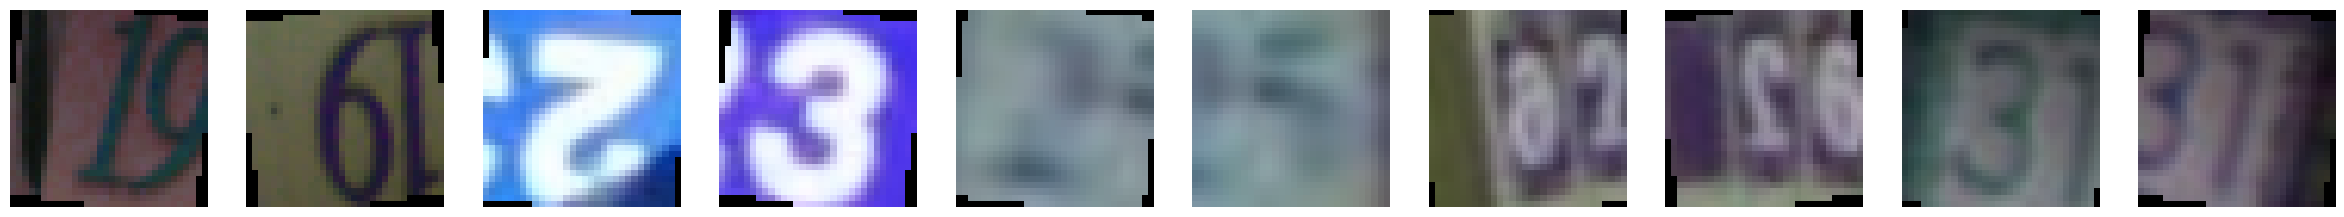

In [13]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./',
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [15]:
# TODO:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                           sampler=train_sampler)

In [16]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.647836, Train accuracy: 0.801386, Val accuracy: 0.839738
Average loss: 0.590350, Train accuracy: 0.820240, Val accuracy: 0.843833
Average loss: 0.567484, Train accuracy: 0.827458, Val accuracy: 0.851409
Average loss: 0.549954, Train accuracy: 0.831280, Val accuracy: 0.846836
Average loss: 0.535531, Train accuracy: 0.836484, Val accuracy: 0.854617


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [17]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 120, 5),
        nn.LeakyReLU(inplace=True),
        Flattener(),
        nn.Linear(120, 84),
        nn.LeakyReLU(inplace=True),
        nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [18]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.294422, Train accuracy: 0.564140, Val accuracy: 0.828885
Average loss: 0.588948, Train accuracy: 0.822049, Val accuracy: 0.853252
Average loss: 0.497624, Train accuracy: 0.849981, Val accuracy: 0.868473
Average loss: 0.453729, Train accuracy: 0.863717, Val accuracy: 0.873114
Average loss: 0.415580, Train accuracy: 0.875678, Val accuracy: 0.884923
Average loss: 0.387697, Train accuracy: 0.884124, Val accuracy: 0.884172
Average loss: 0.372436, Train accuracy: 0.888646, Val accuracy: 0.883353
Average loss: 0.354865, Train accuracy: 0.894345, Val accuracy: 0.896867
Average loss: 0.341768, Train accuracy: 0.896854, Val accuracy: 0.896662
Average loss: 0.332434, Train accuracy: 0.899874, Val accuracy: 0.893045


# Подбор гиперпараметров

In [24]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-3]
anneal_coeff = 0.2
anneal_epochs = [2, 5]
regs = [1e-3, 1e-4]

batch_size = 64
epoch_num = 6

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

# Use grid search or random search and record all runs in run_record dictionnary
# Important: perform search in logarithmic space!

for lr in learning_rates:
    for anneal_epoch in anneal_epochs:
        for reg in regs:
            lenet_model = nn.Sequential(
                nn.Conv2d(3, 6, kernel_size=(5, 5)),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                nn.Tanh(),
                nn.Conv2d(6, 16, kernel_size=(5, 5)),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                nn.Tanh(),
                Flattener(),
                nn.Linear(16 * 5 * 5, 120),
                nn.Tanh(),
                nn.Linear(120, 84),
                nn.Tanh(),
                nn.Linear(84, 10)
                )

            lenet_model.type(torch.cuda.FloatTensor)
            lenet_model.to(device)

            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

            params = Hyperparams(lr, anneal_epoch, reg)
            optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff)

            loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler)

            result = RunResult(lenet_model, train_history, val_history, val_history[-1])
            run_record[params] = result

Average loss: 1.329743, Train accuracy: 0.552776, Val accuracy: 0.826974
Average loss: 0.617647, Train accuracy: 0.810275, Val accuracy: 0.862535
Average loss: 0.533520, Train accuracy: 0.837559, Val accuracy: 0.859464
Average loss: 0.492126, Train accuracy: 0.849862, Val accuracy: 0.864310
Average loss: 0.462259, Train accuracy: 0.858342, Val accuracy: 0.869633
Average loss: 0.446027, Train accuracy: 0.862830, Val accuracy: 0.885742
Average loss: 1.307605, Train accuracy: 0.557844, Val accuracy: 0.808068
Average loss: 0.632623, Train accuracy: 0.806095, Val accuracy: 0.849908
Average loss: 0.534836, Train accuracy: 0.836433, Val accuracy: 0.861716
Average loss: 0.485207, Train accuracy: 0.851397, Val accuracy: 0.875299
Average loss: 0.450023, Train accuracy: 0.861465, Val accuracy: 0.875230
Average loss: 0.429712, Train accuracy: 0.866123, Val accuracy: 0.875435
Average loss: 1.306311, Train accuracy: 0.557656, Val accuracy: 0.825541
Average loss: 0.618301, Train accuracy: 0.810207, V

In [25]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))


Best validation accuracy: 0.89, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=2, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = None

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
best_model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 5, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, 5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 128, 5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            Flattener(),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(64, 10)
          )

for module in best_model.parameters():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))


best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=1e-3, weight_decay=1e-6)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20)

Average loss: 0.955270, Train accuracy: 0.691926, Val accuracy: 0.874684
Average loss: 0.511566, Train accuracy: 0.842866, Val accuracy: 0.898778
Average loss: 0.431956, Train accuracy: 0.868307, Val accuracy: 0.910450
Average loss: 0.394514, Train accuracy: 0.880200, Val accuracy: 0.920483
Average loss: 0.361069, Train accuracy: 0.892008, Val accuracy: 0.921234
Average loss: 0.334340, Train accuracy: 0.899976, Val accuracy: 0.929015
Average loss: 0.316349, Train accuracy: 0.906034, Val accuracy: 0.930585
Average loss: 0.308016, Train accuracy: 0.906955, Val accuracy: 0.934407
Average loss: 0.289202, Train accuracy: 0.912279, Val accuracy: 0.934544
Average loss: 0.273163, Train accuracy: 0.918916, Val accuracy: 0.936182
Average loss: 0.265342, Train accuracy: 0.920384, Val accuracy: 0.937547
Average loss: 0.255249, Train accuracy: 0.922636, Val accuracy: 0.938366
Average loss: 0.243599, Train accuracy: 0.927328, Val accuracy: 0.940482
Average loss: 0.240431, Train accuracy: 0.928028, V